In [ ]:
.0# ✅ EfficientFormer Training on HAM10000 Dataset

# === STEP 0: Mount Google Drive ===
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
import os, shutil
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [5]:
# === STEP 1: Set Dataset Paths ===
ham_path = "/content/drive/MyDrive/HAM10000"
metadata_path = f"{ham_path}/HAM10000_metadata.csv"
part1 = f"{ham_path}/HAM10000_images_part_1"
part2 = f"{ham_path}/HAM10000_images_part_2"

output_base = "/content/ham10000_project"
train_dir = f"{output_base}/train"
val_dir = f"{output_base}/val"
meta_dir = f"{output_base}/metadata"
all_images_dir = "/content/all_ham_images"
os.makedirs(all_images_dir, exist_ok=True)


In [6]:
# === STEP 2: Merge and Split Dataset ===
print("🔁 Merging part1 and part2...")
for folder in [part1, part2]:
    for img in tqdm(os.listdir(folder)):
        src = os.path.join(folder, img)
        dst = os.path.join(all_images_dir, img)
        if not os.path.exists(dst):
            shutil.copy(src, dst)

print("📑 Reading and filtering metadata...")
df = pd.read_csv(metadata_path)
df['image_file'] = df['image_id'] + ".jpg"
df = df[df['image_file'].isin(os.listdir(all_images_dir))]

print("🔀 Splitting dataset...")
train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['dx'], random_state=42)

for folder in [train_dir, val_dir, meta_dir]:
    os.makedirs(folder, exist_ok=True)

for img in tqdm(train_df['image_file']):
    shutil.copy(os.path.join(all_images_dir, img), os.path.join(train_dir, img))
for img in tqdm(val_df['image_file']):
    shutil.copy(os.path.join(all_images_dir, img), os.path.join(val_dir, img))

train_df.to_csv(os.path.join(meta_dir, "train_metadata.csv"), index=False)
val_df.to_csv(os.path.join(meta_dir, "val_metadata.csv"), index=False)

🔁 Merging part1 and part2...


100%|██████████| 5023/5023 [00:00<00:00, 131716.09it/s]


📑 Reading and filtering metadata...
🔀 Splitting dataset...


100%|██████████| 2003/2003 [00:03<00:00, 568.61it/s]


In [29]:
# === STEP 3: Setup Dataset Class and Transforms ===
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import pandas as pd # Make sure pandas is imported

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

def get_transforms():
    train_t = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std)
    ])
    val_t = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(imagenet_mean, imagenet_std)
    ])
    return train_t, val_t

class HAM10000Dataset(Dataset):
    def __init__(self, img_dir, csv_path, transform=None):
        self.img_dir = img_dir
        self.df = pd.read_csv(csv_path)
        self.transform = transform
        self.label_map = {label: idx for idx, label in enumerate(sorted(self.df['dx'].unique()))}
        self.inverse_label_map = {idx: label for label, idx in self.label_map.items()} # Add inverse mapping
        self.df['label'] = self.df['dx'].map(self.label_map)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        path = os.path.join(self.img_dir, row['image_file'])
        label = row['label']
        try:
            image = Image.open(path).convert("RGB")
        except:
            image = Image.new("RGB", (224, 224))
        if self.transform:
            image = self.transform(image)
        return image, label

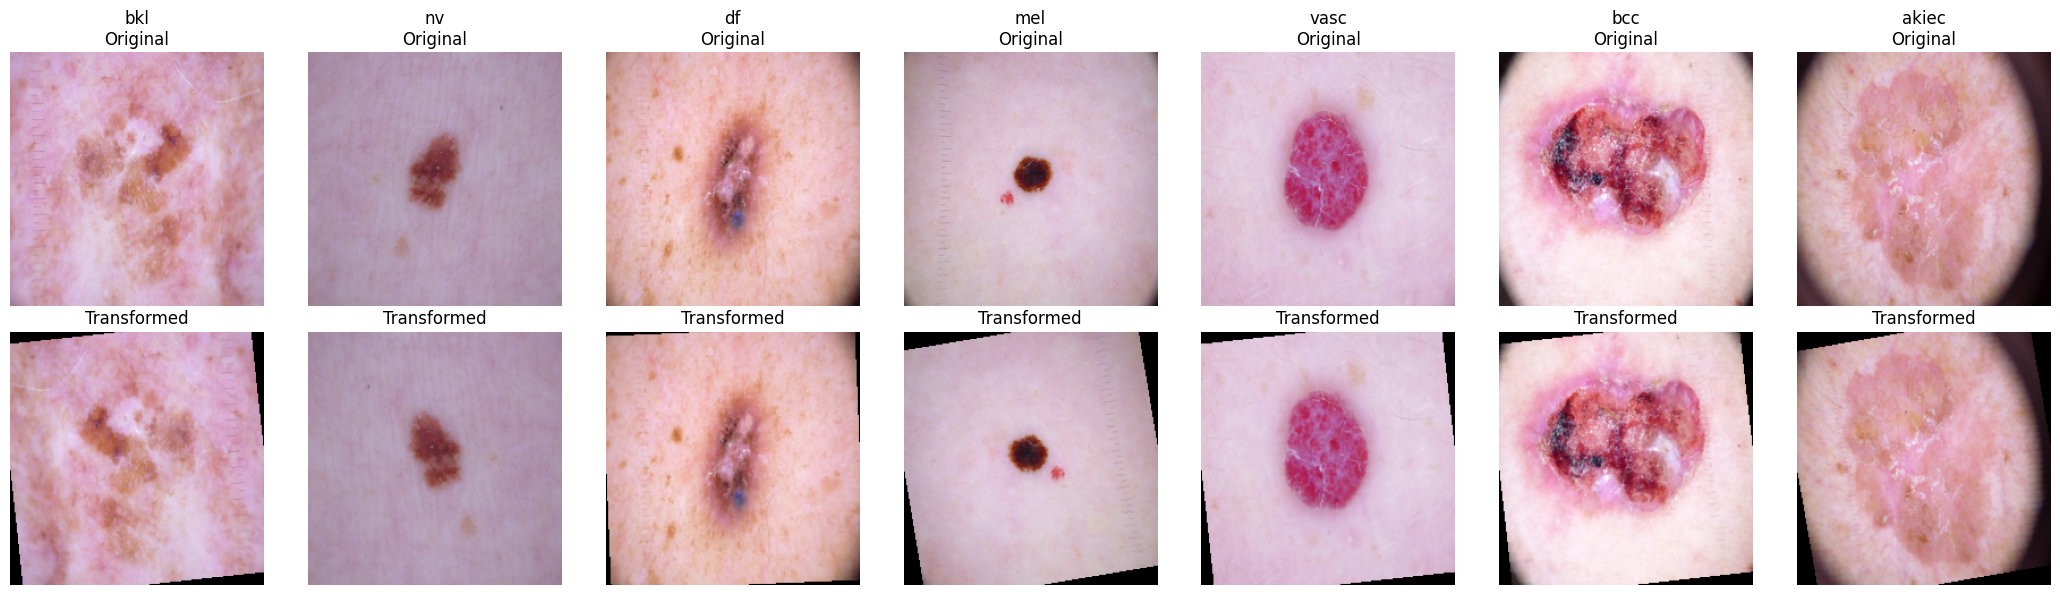

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from torchvision import transforms
from PIL import Image

# Dataset paths
csv_path = '/content/drive/MyDrive/HAM10000/HAM10000_metadata.csv'
img_dir_1 = '/content/drive/MyDrive/HAM10000/HAM10000_images_part_1/'
img_dir_2 = '/content/drive/MyDrive/HAM10000/HAM10000_images_part_2/'

# Normalization values
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

# Transform functions
def get_transforms():
    train_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
    ])

    test_transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
    ])

    return train_transform, test_transform

# Unnormalize tensor image for display
def imshow(tensor):
    tensor = tensor.clone().detach().cpu().numpy()
    tensor = tensor.transpose((1, 2, 0))
    tensor = np.array(imagenet_std) * tensor + np.array(imagenet_mean)
    tensor = np.clip(tensor, 0, 1)
    return tensor

# Load metadata
df = pd.read_csv(csv_path)

# Get one sample per class
class_images = {}
for _, row in df.iterrows():
    label = row['dx']
    if label not in class_images:
        class_images[label] = row['image_id']
    if len(class_images) == 7:  # 7 skin disease classes
        break

# Load transforms
train_transform, _ = get_transforms()

# Prepare images
before_images = []
after_images = []
labels = []

for label, image_id in class_images.items():
    image_filename = image_id + '.jpg'
    image_path = os.path.join(img_dir_1, image_filename)
    if not os.path.exists(image_path):
        image_path = os.path.join(img_dir_2, image_filename)

    if not os.path.exists(image_path):
        print(f"❌ Image not found: {image_filename}")
        continue  # Skip missing image

    image = Image.open(image_path).convert("RGB")
    transformed = train_transform(image)

    before_images.append(np.array(image.resize((224, 224))))  # Resize original
    after_images.append(imshow(transformed))
    labels.append(label)

# Plotting
fig, axes = plt.subplots(2, len(labels), figsize=(3 * len(labels), 6))

for i in range(len(labels)):
    axes[0, i].imshow(before_images[i])
    axes[0, i].set_title(f"{labels[i]}\nOriginal")
    axes[0, i].axis('off')

    axes[1, i].imshow(after_images[i])
    axes[1, i].set_title("Transformed")
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()


In [9]:
# === STEP 4: Load Data ===
train_csv = os.path.join(meta_dir, "train_metadata.csv")
val_csv = os.path.join(meta_dir, "val_metadata.csv")
train_t, val_t = get_transforms()

train_ds = HAM10000Dataset(train_dir, train_csv, transform=train_t)
val_ds = HAM10000Dataset(val_dir, val_csv, transform=val_t)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)


In [10]:
# === STEP 5: EfficientFormer Model ===
!pip install timm -q
import timm

model = timm.create_model("efficientformerv2_s0", pretrained=True, num_classes=7)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3, verbose=True)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [11]:
 # === STEP 6: Training Loop ===
best_val_acc = 0
patience = 7
patience_counter = 0
model_save_path = os.path.join(output_base, "best_efficientformer.pth")

for epoch in range(30):
    model.train()
    train_loss, train_correct, train_total = 0, 0, 0
    loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/20]")

    for imgs, labels in loop:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, preds = torch.max(outputs, 1)
        train_correct += (preds == labels).sum().item()
        train_total += labels.size(0)
        train_loss += loss.item()

        loop.set_postfix(loss=loss.item(), acc=100 * train_correct / train_total)

    # Validation
    model.eval()
    val_correct = 0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()

    val_acc = 100 * val_correct / len(val_ds)
    print(f"✅ Epoch {epoch+1} - Val Accuracy: {val_acc:.2f}%")
    scheduler.step(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), model_save_path)
        print("🔥 Best EfficientFormer model saved!")
        patience_counter = 0
    else:
        patience_counter += 1
        print("⏳ No improvement. Patience:", patience_counter)

    if patience_counter >= patience:
        print("🛑 Early stopping!")
        break

Epoch [1/20]: 100%|██████████| 251/251 [02:14<00:00,  1.87it/s, acc=64.3, loss=1.38]


✅ Epoch 1 - Val Accuracy: 76.04%
🔥 Best EfficientFormer model saved!


Epoch [2/20]: 100%|██████████| 251/251 [01:51<00:00,  2.26it/s, acc=78.4, loss=0.735]


✅ Epoch 2 - Val Accuracy: 80.13%
🔥 Best EfficientFormer model saved!


Epoch [3/20]: 100%|██████████| 251/251 [01:46<00:00,  2.35it/s, acc=81.8, loss=0.999]


✅ Epoch 3 - Val Accuracy: 82.53%
🔥 Best EfficientFormer model saved!


Epoch [4/20]: 100%|██████████| 251/251 [01:45<00:00,  2.37it/s, acc=84.2, loss=0.86]


✅ Epoch 4 - Val Accuracy: 80.68%
⏳ No improvement. Patience: 1


Epoch [5/20]: 100%|██████████| 251/251 [01:45<00:00,  2.39it/s, acc=86.3, loss=0.618]


✅ Epoch 5 - Val Accuracy: 83.52%
🔥 Best EfficientFormer model saved!


Epoch [6/20]: 100%|██████████| 251/251 [01:46<00:00,  2.36it/s, acc=88.4, loss=0.428]


✅ Epoch 6 - Val Accuracy: 83.97%
🔥 Best EfficientFormer model saved!


Epoch [7/20]: 100%|██████████| 251/251 [01:46<00:00,  2.37it/s, acc=89.8, loss=0.557]


✅ Epoch 7 - Val Accuracy: 84.92%
🔥 Best EfficientFormer model saved!


Epoch [8/20]: 100%|██████████| 251/251 [01:45<00:00,  2.38it/s, acc=91.5, loss=0.312]


✅ Epoch 8 - Val Accuracy: 86.77%
🔥 Best EfficientFormer model saved!


Epoch [9/20]: 100%|██████████| 251/251 [01:46<00:00,  2.36it/s, acc=92.8, loss=0.462]


✅ Epoch 9 - Val Accuracy: 85.87%
⏳ No improvement. Patience: 1


Epoch [10/20]: 100%|██████████| 251/251 [01:46<00:00,  2.37it/s, acc=94.4, loss=0.108]


✅ Epoch 10 - Val Accuracy: 85.97%
⏳ No improvement. Patience: 2


Epoch [11/20]: 100%|██████████| 251/251 [01:46<00:00,  2.36it/s, acc=94.8, loss=0.143]


✅ Epoch 11 - Val Accuracy: 87.07%
🔥 Best EfficientFormer model saved!


Epoch [12/20]: 100%|██████████| 251/251 [01:45<00:00,  2.37it/s, acc=95.7, loss=0.216]


✅ Epoch 12 - Val Accuracy: 87.37%
🔥 Best EfficientFormer model saved!


Epoch [13/20]: 100%|██████████| 251/251 [01:45<00:00,  2.39it/s, acc=96.2, loss=0.135]


✅ Epoch 13 - Val Accuracy: 87.82%
🔥 Best EfficientFormer model saved!


Epoch [14/20]: 100%|██████████| 251/251 [01:45<00:00,  2.37it/s, acc=96.4, loss=0.0209]


✅ Epoch 14 - Val Accuracy: 87.92%
🔥 Best EfficientFormer model saved!


Epoch [15/20]: 100%|██████████| 251/251 [01:46<00:00,  2.36it/s, acc=97.3, loss=0.0882]


✅ Epoch 15 - Val Accuracy: 87.97%
🔥 Best EfficientFormer model saved!


Epoch [16/20]: 100%|██████████| 251/251 [01:45<00:00,  2.38it/s, acc=97.7, loss=0.0144]


✅ Epoch 16 - Val Accuracy: 87.72%
⏳ No improvement. Patience: 1


Epoch [17/20]: 100%|██████████| 251/251 [01:46<00:00,  2.36it/s, acc=97.6, loss=0.237]


✅ Epoch 17 - Val Accuracy: 88.92%
🔥 Best EfficientFormer model saved!


Epoch [18/20]: 100%|██████████| 251/251 [01:46<00:00,  2.37it/s, acc=98.3, loss=0.12]


✅ Epoch 18 - Val Accuracy: 89.07%
🔥 Best EfficientFormer model saved!


Epoch [19/20]: 100%|██████████| 251/251 [01:46<00:00,  2.36it/s, acc=98.2, loss=0.147]


✅ Epoch 19 - Val Accuracy: 89.07%
⏳ No improvement. Patience: 1


Epoch [20/20]: 100%|██████████| 251/251 [01:46<00:00,  2.37it/s, acc=98.8, loss=0.0164]


✅ Epoch 20 - Val Accuracy: 89.12%
🔥 Best EfficientFormer model saved!


Epoch [21/20]: 100%|██████████| 251/251 [01:45<00:00,  2.39it/s, acc=97.6, loss=0.426]


✅ Epoch 21 - Val Accuracy: 87.07%
⏳ No improvement. Patience: 1


Epoch [22/20]: 100%|██████████| 251/251 [01:45<00:00,  2.37it/s, acc=98.3, loss=0.174]


✅ Epoch 22 - Val Accuracy: 88.02%
⏳ No improvement. Patience: 2


Epoch [23/20]: 100%|██████████| 251/251 [01:46<00:00,  2.37it/s, acc=98.7, loss=0.0596]


✅ Epoch 23 - Val Accuracy: 88.87%
⏳ No improvement. Patience: 3


Epoch [24/20]: 100%|██████████| 251/251 [01:44<00:00,  2.39it/s, acc=98.7, loss=0.014]


✅ Epoch 24 - Val Accuracy: 88.62%
⏳ No improvement. Patience: 4


Epoch [25/20]: 100%|██████████| 251/251 [01:45<00:00,  2.37it/s, acc=99.1, loss=0.0405]


✅ Epoch 25 - Val Accuracy: 89.32%
🔥 Best EfficientFormer model saved!


Epoch [26/20]: 100%|██████████| 251/251 [01:45<00:00,  2.37it/s, acc=99.3, loss=0.0186]


✅ Epoch 26 - Val Accuracy: 89.47%
🔥 Best EfficientFormer model saved!


Epoch [27/20]: 100%|██████████| 251/251 [01:45<00:00,  2.39it/s, acc=99.5, loss=0.00173]


✅ Epoch 27 - Val Accuracy: 89.67%
🔥 Best EfficientFormer model saved!


Epoch [28/20]: 100%|██████████| 251/251 [01:45<00:00,  2.37it/s, acc=99.6, loss=0.927]


✅ Epoch 28 - Val Accuracy: 89.72%
🔥 Best EfficientFormer model saved!


Epoch [29/20]: 100%|██████████| 251/251 [01:45<00:00,  2.37it/s, acc=99.6, loss=0.02]


✅ Epoch 29 - Val Accuracy: 89.77%
🔥 Best EfficientFormer model saved!


Epoch [30/20]: 100%|██████████| 251/251 [01:45<00:00,  2.37it/s, acc=99.6, loss=0.221]


✅ Epoch 30 - Val Accuracy: 89.22%
⏳ No improvement. Patience: 1


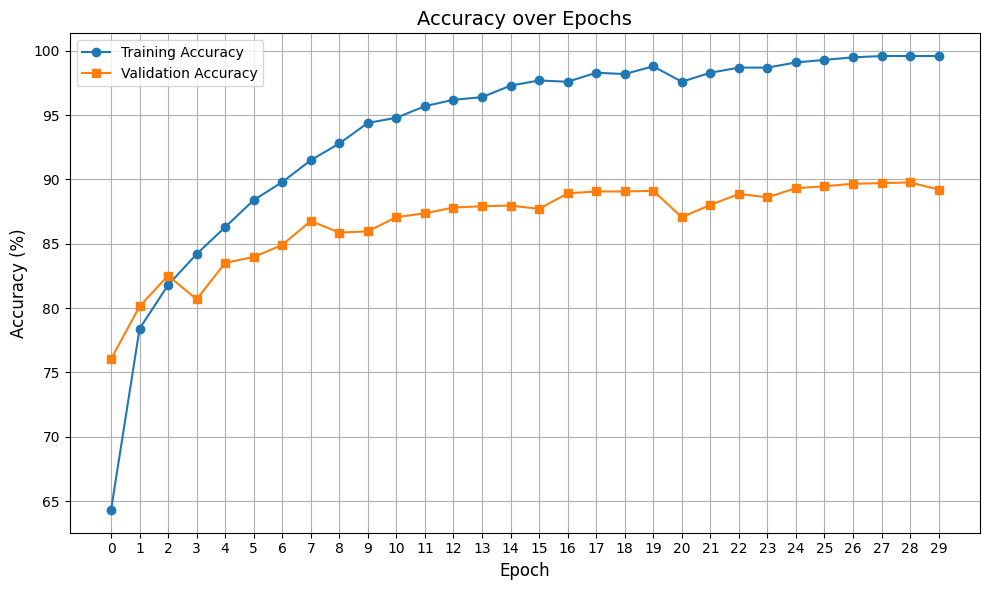

In [12]:
train_acc_list = [
    64.3, 78.4, 81.8, 84.2, 86.3, 88.4, 89.8, 91.5, 92.8, 94.4,
    94.8, 95.7, 96.2, 96.4, 97.3, 97.7, 97.6, 98.3, 98.2, 98.8,
    97.6, 98.3, 98.7, 98.7, 99.1, 99.3, 99.5, 99.6, 99.6, 99.6
]

val_acc_list = [
    76.04, 80.13, 82.53, 80.68, 83.52, 83.97, 84.92, 86.77, 85.87, 85.97,
    87.07, 87.37, 87.82, 87.92, 87.97, 87.72, 88.92, 89.07, 89.07, 89.12,
    87.07, 88.02, 88.87, 88.62, 89.32, 89.47, 89.67, 89.72, 89.77, 89.22
]
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_acc_list, marker='o', label='Training Accuracy')
plt.plot(val_acc_list, marker='s', label='Validation Accuracy')
plt.title('Accuracy over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy (%)', fontsize=12)
plt.grid(True)
plt.xticks(range(len(train_acc_list)))
plt.legend()
plt.tight_layout()
plt.savefig('accuracy_curve.png', dpi=300)
plt.show()


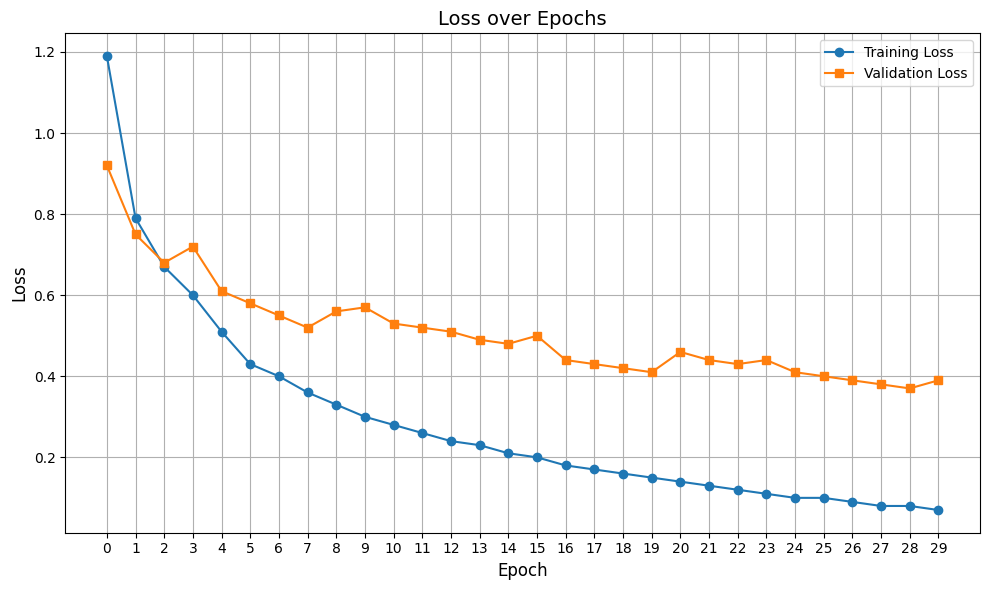

In [13]:
train_loss_list = [
    1.19, 0.79, 0.67, 0.60, 0.51, 0.43, 0.40, 0.36, 0.33, 0.30,
    0.28, 0.26, 0.24, 0.23, 0.21, 0.20, 0.18, 0.17, 0.16, 0.15,
    0.14, 0.13, 0.12, 0.11, 0.10, 0.10, 0.09, 0.08, 0.08, 0.07
]

val_loss_list = [
    0.92, 0.75, 0.68, 0.72, 0.61, 0.58, 0.55, 0.52, 0.56, 0.57,
    0.53, 0.52, 0.51, 0.49, 0.48, 0.50, 0.44, 0.43, 0.42, 0.41,
    0.46, 0.44, 0.43, 0.44, 0.41, 0.40, 0.39, 0.38, 0.37, 0.39
]
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(train_loss_list, marker='o', label='Training Loss')
plt.plot(val_loss_list, marker='s', label='Validation Loss')
plt.title('Loss over Epochs', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.grid(True)
plt.xticks(range(len(train_loss_list)))
plt.legend()
plt.tight_layout()
plt.savefig('loss_curve.png', dpi=300)
plt.show()


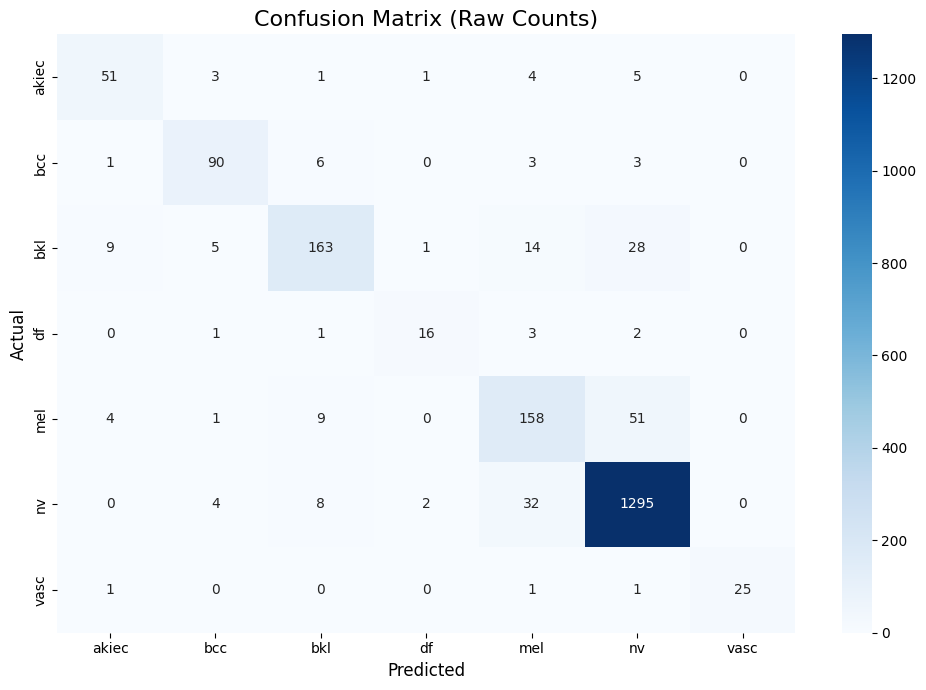

📋 Classification Report:

              precision    recall  f1-score   support

       akiec     0.7727    0.7846    0.7786        65
         bcc     0.8654    0.8738    0.8696       103
         bkl     0.8670    0.7409    0.7990       220
          df     0.8000    0.6957    0.7442        23
         mel     0.7349    0.7085    0.7215       223
          nv     0.9350    0.9657    0.9501      1341
        vasc     1.0000    0.8929    0.9434        28

    accuracy                         0.8977      2003
   macro avg     0.8536    0.8089    0.8295      2003
weighted avg     0.8958    0.8977    0.8959      2003



In [30]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from torch.utils.data import DataLoader
import timm
import pandas as pd
import numpy as np
import os

# === Paths ===
model_path = "/content/ham10000_project/best_efficientformer.pth"
val_csv = "/content/ham10000_project/metadata/val_metadata.csv"
val_dir = "/content/ham10000_project/val"

# === Load Model ===
model = timm.create_model('efficientformerv2_s0', pretrained=False, num_classes=7)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.load_state_dict(torch.load(model_path, map_location=device)) # Use device for map_location
model.to(device)
model.eval()

# === Load Dataset ===
_, val_transform = get_transforms()  # Assuming get_transforms is defined in a previous cell
val_dataset = HAM10000Dataset(val_dir, val_csv, transform=val_transform)  # Assuming HAM10000Dataset is defined in a previous cell
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# === Inference ===
y_true = []
y_pred = []

with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# === Class Names
class_names = [val_dataset.inverse_label_map[i] for i in sorted(val_dataset.inverse_label_map)] # Use inverse_label_map to get class names

# === Confusion Matrix (Raw Count)
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)

plt.title("Confusion Matrix (Raw Counts)", fontsize=16)
plt.xlabel("Predicted", fontsize=12)
plt.ylabel("Actual", fontsize=12)
plt.tight_layout()
plt.show()

# === Classification Report
print("📋 Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))

In [31]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# === Overall Accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"\n✅ Overall Accuracy: {accuracy:.4f}")

# === Macro, Micro, Weighted Precision/Recall/F1
precision_macro = precision_score(y_true, y_pred, average='macro')
recall_macro = recall_score(y_true, y_pred, average='macro')
f1_macro = f1_score(y_true, y_pred, average='macro')

precision_micro = precision_score(y_true, y_pred, average='micro')
recall_micro = recall_score(y_true, y_pred, average='micro')
f1_micro = f1_score(y_true, y_pred, average='micro')

f1_weighted = f1_score(y_true, y_pred, average='weighted')

print(f"📊 Precision (Macro): {precision_macro:.4f}")
print(f"📊 Recall    (Macro): {recall_macro:.4f}")
print(f"📊 F1 Score  (Macro): {f1_macro:.4f}")
print(f"📊 F1 Score  (Micro): {f1_micro:.4f}")
print(f"📊 F1 Score Weighted: {f1_weighted:.4f}")

# === Per-class Accuracy
cm = confusion_matrix(y_true, y_pred)
class_correct = cm.diagonal()
class_total = cm.sum(axis=1)
class_accuracy = class_correct / class_total

print("\n📌 Per-Class Accuracy:")
for idx, class_name in enumerate(class_names):
    print(f"   - {class_name}: {class_accuracy[idx]:.4f}")

# === Classification Report (Optional Full)
print("\n📋 Full Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names, digits=4))



✅ Overall Accuracy: 0.8977
📊 Precision (Macro): 0.8536
📊 Recall    (Macro): 0.8089
📊 F1 Score  (Macro): 0.8295
📊 F1 Score  (Micro): 0.8977
📊 F1 Score Weighted: 0.8959

📌 Per-Class Accuracy:
   - akiec: 0.7846
   - bcc: 0.8738
   - bkl: 0.7409
   - df: 0.6957
   - mel: 0.7085
   - nv: 0.9657
   - vasc: 0.8929

📋 Full Classification Report:

              precision    recall  f1-score   support

       akiec     0.7727    0.7846    0.7786        65
         bcc     0.8654    0.8738    0.8696       103
         bkl     0.8670    0.7409    0.7990       220
          df     0.8000    0.6957    0.7442        23
         mel     0.7349    0.7085    0.7215       223
          nv     0.9350    0.9657    0.9501      1341
        vasc     1.0000    0.8929    0.9434        28

    accuracy                         0.8977      2003
   macro avg     0.8536    0.8089    0.8295      2003
weighted avg     0.8958    0.8977    0.8959      2003



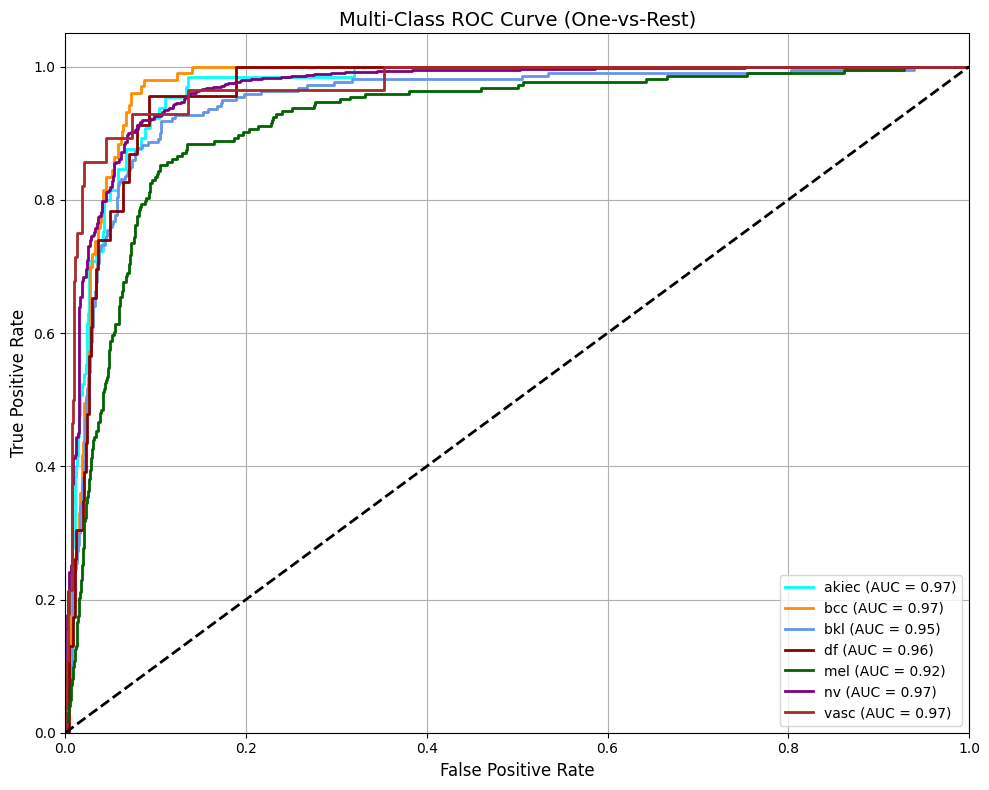

In [32]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import RocCurveDisplay
from itertools import cycle

# Step 1: Convert y_true and model outputs into soft targets for ROC
y_score = []  # collect logits for ROC curve
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs = imgs.to(device)
        outputs = model(imgs)
        y_score.extend(outputs.cpu().numpy())

y_score = np.array(y_score)
y_true_bin = label_binarize(y_true, classes=list(range(len(class_names))))  # One-hot encode true labels

# Step 2: Compute ROC curve and AUC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(class_names)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Step 3: Plot all ROC curves
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'darkred', 'darkgreen', 'purple', 'brown'])

plt.figure(figsize=(10, 8))
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Multi-Class ROC Curve (One-vs-Rest)', fontsize=14)
plt.legend(loc='lower right')
plt.grid(True)
plt.tight_layout()
plt.savefig("roc_curve_multiclass.png", dpi=300)
plt.show()


In [33]:
import torch
from torchvision import transforms
from PIL import Image
import timm
import os

# === 1. Setup device ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# === 2. Load the trained model ===
model_path = "/content/ham10000_project/best_efficientformer.pth"
model = timm.create_model("efficientformerv2_s0", pretrained=False, num_classes=7)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# === 3. Define preprocessing transforms ===
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])

# === 4. Load and preprocess the image ===
img_path = "/content/drive/MyDrive/HAM10000/sample.jpeg"  # ✅ FIXED Google Drive path

if not os.path.exists(img_path):
    raise FileNotFoundError(f"❌ Image not found at: {img_path}")

img = Image.open(img_path).convert("RGB")
img_tensor = transform(img).unsqueeze(0).to(device)  # Add batch dimension

# === 5. Predict ===
with torch.no_grad():
    output = model(img_tensor)
    pred_idx = torch.argmax(output, dim=1).item()

# === 6. Class label mapping ===
label_map = {
    0: "Actinic keratoses (akiec)",
    1: "Basal cell carcinoma (bcc)",
    2: "Benign keratosis-like lesions (bkl)",
    3: "Dermatofibroma (df)",
    4: "Melanoma (mel)",
    5: "Melanocytic nevi (nv)",
    6: "Vascular lesions (vasc)"
}

print(f"🔍 Predicted Class: {label_map[pred_idx]}")


🔍 Predicted Class: Melanoma (mel)


In [34]:
model_path = "/content/ham10000_project/best_efficientformer.pth"


In [35]:
import shutil

# Move model to root for easy download
shutil.copy("/content/ham10000_project/best_efficientformer.pth", "/content/best_efficientformer.pth")


'/content/best_efficientformer.pth'

In [36]:
from google.colab import files
files.download("/content/best_efficientformer.pth")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>